In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys
sys.path.append('/content/drive/MyDrive/DCDP')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

import itertools

from cpd_utils import *

import time
import bisect

import pandas as pd

In [3]:
def generate_data_mean(n, T, theta):
    p = len(theta[0])
    y_train = np.concatenate([np.random.multivariate_normal(theta[i], np.eye(p), n[i]) for i in range(T)])
    y_train_joint = y_train.reshape((-1, p))
    nt = len(y_train_joint)
    
    return nt, y_train_joint

----------------------------

In [4]:
T = 4
Delta = 5000
nt = Delta * T
n = np.array([Delta] * T)
cp_truth = np.cumsum(n)[:T-1]

theta = np.array([[0], [5], [0], [5]])

diff = np.zeros(T - 1)
for t in range(1, T):
    diff[t - 1] = np.sum(np.abs(theta[t] - theta[t - 1])**2)**0.5
    
Q_grid_list = [25,50,75,100,125,150,175,200]
Q = len(Q_grid_list)

gamma_list = [2000, 3000, 4000]
lam_list = [0]

B = 100

run_time_dc = np.zeros((Q, B))
loc_error_dc = np.zeros((Q, B))
cp_best_list = {}
param_best_list = {}

run_time_d = np.zeros((Q, B))
loc_error_d = np.zeros((Q, B))
cp_best_d_list = {}
param_best_d_list = {}

s = time.time()
for q, grid_n in enumerate(Q_grid_list):
    cp_best_list[q] = []
    param_best_list[q] = []
    
    cp_best_d_list[q] = []
    param_best_d_list[q] = []
    for b in range(B):
        np.random.seed(b)
        n = np.array([Delta] * T) + np.random.uniform(-0.3*Delta, 0.3*Delta, T).astype(int)
        n[-1] = nt - np.sum(n[:-1])
        cp_truth = np.cumsum(n)[:T-1]
        
        nt, Y_train = generate_data_mean(n, T, theta)
        nt, Y_test = generate_data_mean(n, T, theta)

        np.random.seed(b)
        start_time = time.time()
        dp_fit = dp_cv_grid_mean(grid_n, lam_list, gamma_list)
        cp_best_d, param_best_d = dp_fit.fit(Y_train, Y_test)
        loc_error_d[q, b] = cp_distance(cp_best_d, cp_truth)
        run_time_d[q, b] = time.time() - start_time
        cp_best_d_list[q].append(cp_best_d)
        param_best_d_list[q].append(param_best_d)

        np.random.seed(b)
        start_time = time.time()
        dcdp_fit = dcdp_cv_grid_mean(grid_n, lam_list, gamma_list)
        cp_best, param_best, cp_best_cand = dcdp_fit.fit(Y_train, Y_test)
        loc_error_dc[q, b] = cp_distance(cp_best, cp_truth)
        run_time_dc[q, b] = time.time() - start_time
        cp_best_list[q].append(cp_best)
        param_best_list[q].append(param_best)
    print(q)

print(time.time() - s)

0
1
2
3
4
5
6
7
5015.465492248535


In [5]:
import pickle
path = '/content/drive/MyDrive/DCDP/'
with open(path + 'Q_time_error_Delta5000.pickle', 'wb') as f:
    pickle.dump([theta, Delta, Q_grid_list, gamma_list, 
                 run_time_dc, loc_error_dc, cp_best_list, param_best_list,
                 run_time_d, loc_error_d, cp_best_d_list, param_best_d_list], f)

In [6]:
# objects = []
# with (path + 'Q_time_error_Delta5000.pickle', "rb")) as openfile:
#     while True:
#         try:
#             objects.append(pickle.load(openfile))
#         except EOFError:
#             break

In [13]:
def curve_with_bar(x, y_list, percent, legend, xlabel, ylabel, save = False, name = None):
    plt.figure(figsize = (10,7))
    for y in y_list:
        plt.fill_between(x, np.quantile(y, percent, axis = 1), np.quantile(y, 1 - percent, axis = 1), alpha = 0.2)
        plt.plot(x, y.mean(axis = 1))
    
    fsize = 25
    plt.legend(legend, fontsize = fsize)
    plt.xlabel(xlabel, fontsize = fsize)
    plt.ylabel(ylabel, fontsize = fsize)
    if save:
        plt.savefig(name)


def pair_curve_with_bar(x1, y1_list, percent1, legend1, xlabel1, ylabel1, 
                        x2, y2_list, percent2, legend2, xlabel2, ylabel2, 
                        save = False, name = None):
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))

    fsize = 25
    tick_size = 15
    for i, y1 in enumerate(y1_list):
        ax[0].fill_between(x1, np.quantile(y1, percent1, axis = 1), np.quantile(y1, 1 - percent1, axis = 1), alpha = 0.2)
        ax[0].plot(x1, y1.mean(axis = 1))
    
        
        # ax[0].legend(legend1, fontsize = fsize)
        ax[0].set_xlabel(xlabel1, fontsize = fsize)
        ax[0].set_ylabel(ylabel1, fontsize = fsize)
        ax[0].tick_params(axis='both', which='major', labelsize=tick_size)

    for i, y2 in enumerate(y2_list):
        ax[1].fill_between(x2, np.quantile(y2, percent2, axis = 1), np.quantile(y2, 1 - percent2, axis = 1), alpha = 0.2)
        ax[1].plot(x2, y2.mean(axis = 1), label = legend2[i])
    
        
        # ax[1].legend(legend2, fontsize = fsize)
        ax[1].set_xlabel(xlabel2, fontsize = fsize)
        ax[1].set_ylabel(ylabel2, fontsize = fsize)
        ax[1].tick_params(axis='both', which='major', labelsize=tick_size)
    
    lines_labels = [ax_.get_legend_handles_labels() for ax_ in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc = 'upper left',  
               ncol = 1, fontsize = fsize,
               bbox_transform = plt.gcf().transFigure)

    # plt.legend(lines, labels, loc = 'lower center', bbox_to_anchor = (0, -0.1, 1, 1),
    #        bbox_transform = plt.gcf().transFigure)
    plt.tight_layout()
    if save:
        plt.savefig(name, bbox_inches = 'tight')

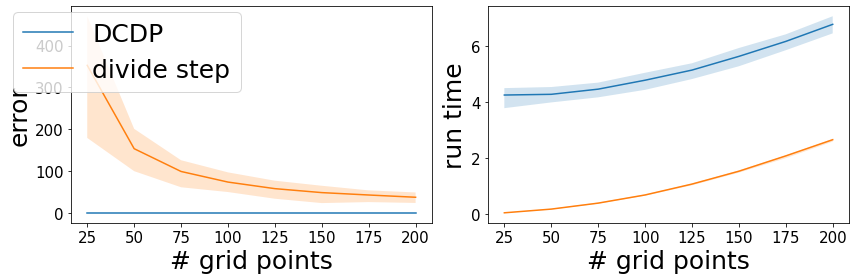

In [14]:
loc_rate_dc = np.array([error  for error, Delta in zip(loc_error_dc, Q_grid_list)])
loc_rate_d = np.array([error for error, Delta in zip(loc_error_d, Q_grid_list)])
pair_curve_with_bar(Q_grid_list, [loc_rate_dc, loc_rate_d], 0.1, ['DCDP', 'divide step'], '# grid points', 'error', 
               Q_grid_list, [run_time_dc, run_time_d], 0.1, ['DCDP', 'divide step'], '# grid points', 'run time',
               save = True, name = path + "Delta5000_time_error_vs_grid_num.pdf")